# Classification of MNIST digits via SVD decomposition

In this homework Singular Value Decomposition is used to classificate MNIST digits.
This dataset, which is loaded in the form of a 256 × 1707 matrix, contains the flattened version of 1707 16 × 16 grayscale handwritten digits between 0 and 9.

A binary classification problem was considered, where it was required to classificate if a given digit of dimension m x n represents the number 3 or the number 4 whose class is C1 and C2 respectively.

After that, a multiclass model is presented following the same steps of the binary classifier.

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import math

## Binary classification

In [5]:
DATA = scipy.io.loadmat('./data/MNIST.mat')

# data-labels split
X = DATA['X'] 
I = DATA['I']

# data shuffling
data = np.concatenate([X,I],0).T
np.random.shuffle(data)             

X = data.T[:-1]
I = data.T[-1]

digits = [3, 4]  # digits we want to classify

idx = np.zeros(I.shape, dtype=bool)

for d in digits:
    idx+=I==d 

X = X[:, idx]
I = I[idx]

train_percentage = 0.80

n = int(X.shape[1]*train_percentage) # number of training samples

# train-test split
X_train = X[:,:n]
X_test = X[:,n:]

I_train = I[:n]
I_test = I[n:]

# class-based split of training set
X1 = X_train[:, np.squeeze(I_train==digits[0])]
X2 = X_train[:, np.squeeze(I_train==digits[1])]

# SVD decomposition of X1 and X2
U1, S1, VT1 = np.linalg.svd(X1, full_matrices=False)
U2, S2, VT2 = np.linalg.svd(X2, full_matrices=False)

for i in range(5):
    i = np.random.randint(X_test.shape[1])

    y = X_test[:,i]           # random unknown digit  
    y = np.expand_dims(y,1)

    u1 = np.expand_dims(U1[:,0],1)
    u2 = np.expand_dims(U2[:,0],1)

    y_p1 = u1 @ u1.T @ y     # projection of y in the space of X1
    y_p2 = u2 @ u2.T @ y     # projection of y in the space of X2

    d1 = np.linalg.norm((y-y_p1), 2)
    d2 = np.linalg.norm((y-y_p2), 2)

    if d1 < d2:
        print(f"Predicted class: 3    | Real class: {int(I_test[i])}")
    else:
        print(f"Predicted class: 4    | Real class: {int(I_test[i])}")
    
    print(f"d1: {d1} | d2: {d2}")
    print()

# accuracy
l = X_test.shape[1]
U = np.concatenate([np.expand_dims(u1,0),np.expand_dims(u2,0)],0)

projections = U @ np.transpose(U, axes=[0,2,1]) @ X_test
distances = np.linalg.norm(projections - np.expand_dims(X_test,0), axis=1)
classification = np.argmin(distances,0)
predictions = np.choose(classification,digits)

accuracy = sum((predictions==I_test))/l

print(f"accuracy:    {accuracy*100} %")

Predicted class: 3    | Real class: 3
d1: 4.546310176573883 | d2: 5.29555849782949

Predicted class: 3    | Real class: 3
d1: 4.498166141515304 | d2: 5.9103819491540275

Predicted class: 4    | Real class: 4
d1: 4.91829144354546 | d2: 4.2377889657223715

Predicted class: 4    | Real class: 4
d1: 6.8196115536142 | d2: 4.686620786595576

Predicted class: 3    | Real class: 3
d1: 3.9502415854706205 | d2: 5.449357612903926

accuracy:    98.0392156862745 %


## Multiclass classification

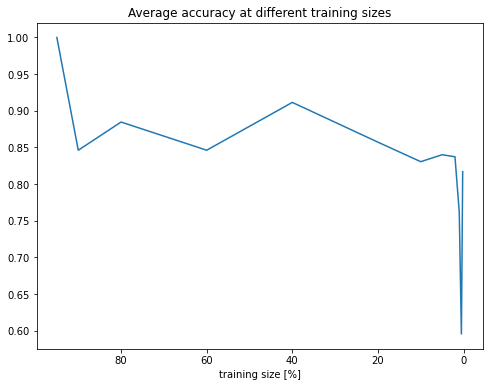

In [7]:
X = DATA['X']
I = DATA['I']

C = pd.Categorical(np.squeeze(I)).categories      # categories extraction

X_divided = {}


for c in C:
    X_divided[c]=X[ :, np.reshape(I==c,-1) ]

percentages_tot = [95,90,80,60,40,20,10,5,2,1,0.5,0.2]

accuracies_tot = np.empty((len(percentages_tot)))

X_v = np.empty((len(percentages_tot),len(C),X.shape[0]))     # principal sigular vectors matrix

for n_p, p in enumerate(percentages_tot):
    n = np.empty((len(C),),dtype=np.int64)    # number of training samples vector
    
    # singular vectors computation
    for c in C:
        
        # data shuffling
        X_divided[c] = X_divided[c].T
        np.random.shuffle(X_divided[c])
        X_divided[c] = X_divided[c].T

        n[c] = math.ceil(X_divided[c].shape[1]*p*0.01)    # size of the train set
        X_train = X_divided[c][:,:n[c]]

        U,S,V = np.linalg.svd(X_train, full_matrices=False)   # SVD

        X_v[n_p][c] = U[:,0]       # principal left singular vector
    
    Xv=np.expand_dims(X_v[n_p],2)
    
    # projections of the test sets on all the subspaces computations
    for c in C:
        X_test = X_divided[c][:,n[c]:]
        l = X_test.shape[1]
        
        projections = Xv @ np.transpose(Xv, axes=[0,2,1]) @ X_test
        
        distances = np.linalg.norm(projections - np.expand_dims(X_test,0), axis=1)

        classification = np.argmin(distances,0)

        for i in range(len(C)):
            tot = sum(classification==i)
            
            if i==c:
                accuracies_tot[n_p] = tot/l

plt.figure(figsize=(8, 6 ))
plt.title('Average accuracy at different training sizes')
plt.plot(percentages_tot,accuracies_tot)
plt.xlabel('training size [%]')
plt.gca().invert_xaxis()